# OntoGen workflow notebook tutorial based on Python script modules for LBD

OntoGen [4] is a semi-automatic data-driven interactive text mining tool that assists users in the creative process of generating topic ontologies by grouping documents into related clusters. 
It is essentially a text mining tool for grouping documents into related clusters that can be viewed as concepts in an automatically created topic ontology. 
The underlying methodology is *𝑘*-means clustering, a particularly popular technique since only the *𝑘* parameter needs to be chosen to determine the number of categories into which documents should be clustered.

<hr>

[1] Petrič, I., Urbančič, T., Cestnik, B., Macedoni-Lukšič, M. (2009). Literature mining method RaLoLink for uncovering relations between biomedical concepts. Journal of Biomedical Informatics, 42(2), 219–227.

[4] Fortuna, B., Grobelnik, M., Mladenić, D. (2006). Semi-automatic data-driven ontology construction system, *Proceedings of the 9th International Multi-conference Information Society*, 223–226.

<hr>

Note that **our motive** was to **re-implement parts** of the tools such as **OntoGen**, RaJoLink and CrossBee so that we can generally **repeat the results** with the tools from the past experiments, and not so much to optimize the written Python code. The fucus was on understanding the learning processes and visualizing the workflows in terms of repeatability of the results obtained; the efficiency and elegance of the programming can be addressed in future versions of the scripts.

Import and initialize `logging` library to track the execution of the scripts.

In [1]:
import logging

# Initialize logging with a basic configuration
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s: %(levelname)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

Import LBD components from the framework notebooks. The description of the individual components from the framework notebooks can be found in the respective notebooks.

The purpose of the **import_ipynb** library is to allow the direct import of Jupyter notebooks as modules so that code, functions and classes defined in one notebook can be easily reused in other notebooks or Python scripts.
If the **import_ipynb** library is omitted (or commented out), the corresponding packages will be imported from **.py** files exported from the **.ipynb** files. Note that importing from **.py** files is usually much faster and therefore more suitable for running scripts in production.

In [2]:
#import import_ipynb
import LBD_01_data_acquisition
import LBD_02_data_preprocessing
import LBD_03_feature_extraction
import LBD_04_text_mining
import LBD_05_results_analysis
import LBD_06_visualization

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bojan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bojan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Import additional Python libraries.

In [3]:
import nltk
import numpy as np
import itertools
import pandas as pd
import spacy
from sklearn.metrics.pairwise import cosine_distances
from typing import List, Dict
from collections import defaultdict

Define the name of the domains $C$ and $A$, then load the responding text from the input file. The expected file format is as follows:

1. The file is encoded in Ascii (if it is in UTF-8 or other encoding, it should be converted to Ascii).
2. Each line in the file represents one document. The words in each document are separated by spaces. The length of the individual documents may vary.
3. The first word in each line is the **unique id**, followed by a semicolon. Normally **pmid** (pubmed id) can be used for this purpose, alhough any unique id (e.g. **sequential count**) suffices.
4. The second word in each line can optionally stand for a predefined domain (or class) of the document. In this case, the second word is preceded by **!**. For example, if the file contains documents that originate from two domains, e.g. *migraine* and *magnesium*, the second word in each line is either **!migraine** or **!magnesium**. If the file contains documents that originate from *autism* and *calcineurin*, the second word in each line will be either **!autism** or **!calcineurin**.
5. If the second word is not preceded by **!**, it will be considered the first word of the document. In this case, the document will be given the domain **!NA** (**not applicable** or **not available**).


**A background story for this experiment**

First, we selected *autism* and *calcineurin* as our domains of interest.

*Autism*  belongs to a group of pervasive developmental disorders that are portrayed by an
early delay and abnormal development of cognitive, communication and social
interaction skills of a person. It is a very complex and not yet sufficiently understood
domain, where precise causes are still unknown; research suggests that it may be
related to genetic mutations, environmental factors, and brain structure and function. 
*Calcineurin* is a protein phosphatase with a high prevalence in the brain.

The dataset from the input file was constructed using the following PubMed query:

1. autis* [TIAB] AND 1900/01/01:2007/12/31 [PDAT]
2. calcineurin [TIAB] AND 1900/01/01:2007/12/31 [PDAT]

The input file *input/f_autism_calcineurin.txt* was prepared for the experiments described in [1]. It contains 13.623 titles and abstracts, 9.403 from *autism* and 4.220 from *calcineurin*.

In this experiment, we use **OntoGen** to detect outlier documents as described in in Chapter 6 *Outlier-based Closed Discovery* in section 6.3 *Outlier document detection and b-term identification through document clustering*.

In the LBD outlier detection approach, each document from the two literatures is an instance represented by a set of words using frequency statistics based on the Bag Of Words (BoW) and Term Frequency–Inverse Document Frequency (TF-IDF) text representations.
The BoW and TF-IDF vectors enable the content similarity of documents to be measured. Content similarity is calculated using OntoGen, where content similarity is measured by cosine distance and the standard TF-IDF word weighting measure, where a high frequency of co-occurring words in documents indicates high document similarity.
The cosine similarity measure is used to position the documents according to their similarity to the representative document (centroid) of a selected domain.
Documents positioned based on the cosine similarity measure can be visualized in OntoGen by a similarity graph with cosine similarity values falling in the interval [0, 1].
The value 0 means extreme dissimilarity, i.e. two documents have no words in common, while the value 1 represents the similarity between two semantically identical documents in the BoW representation.

In [4]:
def truncate_with_ellipsis(string: str, length: int) -> str:
    """
    Truncate a string to a specified length and add ellipsis (...) if it's longer than the length.
    
    Parameters:
    - string (str): the string to be truncated
    - length (int): the maximum allowed length of the truncated string
    
    Returns:
    - str: the truncated string with ellipsis (...) if truncation occurred
    """
    if len(string) > length:
        return string[:length - 3] + '...'  # Adjust for the length of the ellipsis
    return string

In [ ]:
# NO
domainName = 'Migraine-Magnesium'
fileName = 'input/Magnesium_Migraine_before1988.txt'
lines = LBD_01_data_acquisition.load_data_from_file(fileName)
lines[:7]

In [ ]:
# NO
domainName = 'Plato dialogues'
fileName = 'input/plato_dialogues_ontogen.txt'
lines = LBD_01_data_acquisition.load_data_from_file(fileName)
lines[:7]

In [ ]:
domainName = 'Alzheimer-Macrobiota'
fileName = 'input/f_alzheimer_gimb.txt'
lines = LBD_01_data_acquisition.load_data_from_file(fileName)
lines[:7]

In [5]:
domainName = 'Autism-Calcineurin'
fileName = 'input/f_autism_calcineurin.txt'
lines = LBD_01_data_acquisition.load_data_from_file(fileName)
# display the first 7 lines of the document
[truncate_with_ellipsis(line, 110) for line in lines[:7]]

2024-11-15 10:33:19: INFO - Loaded 13623 lines from "input/f_autism_calcineurin.txt".


['19030398: !Autism Autistic spectrum disorder: No causal relationship with vaccines. \n',
 '18985132: !Autism Differential effects of tryptophan depletion on emotion processing according to face dire...',
 '18985106: !Autism Looking you in the mouth: abnormal gaze in autism resulting from impaired top-down modula...',
 '18985105: !Autism Autism-lessons from the X chromosome. Recognized cases of autism spectrum disorders are o...',
 '18985104: !Autism Model syndromes for investigating social cognitive and affective neuroscience: a comparis...',
 '18982120: !Autism The intense world syndrome--an alternative hypothesis for autism. Autism is a devastating...',
 '18958184: !Autism Social approach behaviors are similar on conventional versus reverse lighting cycles, and...']

**Preprocess the documents into a dictionary - might take a few minutes for longer files**

The script in the next cell is used to prepare text data for further analysis in Literature-Based Discovery (LBD). The aim is to clean, standardize and structure the documents so that they are suitable for further tasks such as feature extraction, topic modeling and the discovery of hidden relationships in the literature. The script prepares the documents stored in `lines` in a dictionary.

**Functionality**

1. *Creating a dictionary from raw data*: The script starts by converting a list of rows into a structured dictionary. 
    - *`construct_dict_from_list`*: this function takes the raw list of text lines (`lines`) and creates a dictionary (`docs_dict`) in which each entry typically represents a document, with a unique identifier as the key and the text of the document as the value.
    - This conversion is important because it puts the text data into a more manageable format that allows efficient processing and retrieval.

2. *Preprocessing of documents*: the script then applies various pre-processing steps to the documents:
    - *Cleaning*: the text is cleaned to remove unwanted characters, punctuation and other errors.
    - *Remove stop words*: frequent words that do not provide meaningful information (e.g. "the", "and") are removed.
    - *Lemmatization*: words are reduced to their base or root form (e.g. "running" becomes "run") to ensure consistency.
    - *Minimum word length*: words shorter than four characters are filtered out.
    - *Keep only nouns*: the parameter `keep_only_nouns=True` ensures that only nouns (and proper nouns) are considered in further analysis, removing other word types like adjactives and verbs. 
    A trained pipeline from *spacy* named *en_core_web_md* is used for the task [https://spacy.io/models/en#en_core_web_md]. Note that this filter uses functions from an external *spacy* library to check every word in the vocabulary of the documents and is therefore time-consuming.
    - *MeSH-specific filtering*: the parameter `keep_only_mesh=False` skips the MeSH filtering in this preprocessing.

3. *Extract document IDs and processed text*:  the script then extracts lists of document IDs and the corresponding preprocessed text:
    - *`extract_ids_list`*: returns a list of document IDs from the preprocessed dictionary to facilitate document lookup and management.
    - *`extract_preprocessed_documents_list`*: extracts the cleaned and processed text for each document to prepare it for feature extraction or other analysis.
By extracting these lists, the script organizes the data in a format that is easy to manipulate in subsequent steps, such as creating a Bag of Words (BoW) model or calculating TF-IDF scores.

**Practical applications**

- *Biomedical research and discovery*: This pre-processing approach is valuable in the biomedical field, where ensuring the relevance and accuracy of terms is critical to discovering new relationships between diseases, drugs and other biological concepts. By focusing on specific vocabularies such as MeSH, researchers can more effectively search the literature for new hypotheses or overlooked relationships.
- *Data preparation for machine learning*: The cleaned and structured data generated by this script can be fed directly into machine learning models for tasks such as document classification or clustering.

**Use**

To use this script effectively:
1. *Prepare the data*: Make sure you have a list of raw text lines (`lines`).
2. *Execute the preprocessing steps*: Run the script to clean, filter and structure the text data.
3. *Extract and analyze*: Use the extracted IDs and processed text for further analysis, e.g. to create models and visualizations or for exploratory research.

In [6]:
# 1. Creating a dictionary from raw data
docs_dict = LBD_02_data_preprocessing.construct_dict_from_list(lines)

# 2. Preprocessing of documents
keep_list = []
# Normally, the original domain names are removed from the vocabulary. If "migraine" and "magnesium" were added to the vocabulary during the comparison, 
# they might dominate the analysis because they are the focus of the study. The alorithms might attach extra importance to these terms 
# and push less obvious but potentially important terms or concepts into the background.
remove_list = ['autism', 'calcineurin']
prep_docs_dict = LBD_02_data_preprocessing.preprocess_docs_dict(
    docs_dict, keep_list = keep_list, remove_list = remove_list, mesh_word_list = [], \
    cleaning = True, remove_stopwords = True, lemmatization = True, \
    min_word_length = 4, keep_only_nouns = False, keep_only_mesh = False, stemming = False, stem_type = None)

# 3. Extract document IDs and processed text
ids_list = LBD_02_data_preprocessing.extract_ids_list(prep_docs_dict)
prep_docs_list = LBD_02_data_preprocessing.extract_preprocessed_documents_list(prep_docs_dict)

2024-11-15 10:33:23: INFO - Text cleaning ...
2024-11-15 10:33:25: INFO - Removing stopwords ...
2024-11-15 10:33:25: INFO - Lemmatization ...
2024-11-15 10:33:32: INFO - Keeping only longer words (>= 4 characters)...
2024-11-15 10:33:32: INFO - Preprocessing finished.


The next three cells show the first dictionary entries, the document IDs (Pubmed) and the pre-processed documents.

When displaying the first few dictionary entries, we can observe the difference between the original and the pre-processed documents.

In [7]:
# display the first 7 dictionary items
truncated_dict = {
    key: {sub_key: truncate_with_ellipsis(value, 110) for sub_key, value in sub_dict.items()}
    for key, sub_dict in itertools.islice(prep_docs_dict.items(), 7)
}
truncated_dict

{'19030398': {'domain': 'Autism',
  'document': 'Autistic spectrum disorder: No causal relationship with vaccines.',
  'preprocessed': 'autistic spectrum disorder causal relationship vaccines'},
 '18985132': {'domain': 'Autism',
  'document': 'Differential effects of tryptophan depletion on emotion processing according to face direction. Reading fac...',
  'preprocessed': 'differential effect tryptophan depletion emotion process accord face direction read facial emotion disrupt ...'},
 '18985106': {'domain': 'Autism',
  'document': 'Looking you in the mouth: abnormal gaze in autism resulting from impaired top-down modulation of visual att...',
  'preprocessed': 'look mouth abnormal gaze result impair topdown modulation visual attention people impair social behavior in...'},
 '18985105': {'domain': 'Autism',
  'document': 'Autism-lessons from the X chromosome. Recognized cases of autism spectrum disorders are on the rise. It is ...',
  'preprocessed': 'autismlessons chromosome recognize

In [8]:
# display the ids of the first 7 documents
ids_list[:7]

['19030398',
 '18985132',
 '18985106',
 '18985105',
 '18985104',
 '18982120',
 '18958184']

In [9]:
# display the preprocessed text for the first 7 documents
[truncate_with_ellipsis(line, 110) for line in prep_docs_list[:7]]

['autistic spectrum disorder causal relationship vaccines',
 'differential effect tryptophan depletion emotion process accord face direction read facial emotion disrupt ...',
 'look mouth abnormal gaze result impair topdown modulation visual attention people impair social behavior in...',
 'autismlessons chromosome recognize case spectrum disorder rise unclear whether increase attributable secula...',
 'model syndromes investigate social cognitive affective neuroscience comparison williams syndrome williams s...',
 'intense world syndromean alternative hypothesis devastate neurodevelopmental disorder polygenetic predispos...',
 'social approach behaviors similar conventional versus reverse light cycle replications across cohorts btbr ...']

**Construct BoW model from important words and n-grams**

The next script continues the feature extraction process and focuses on refining a Bag of Words (BoW) model by filtering out less important terms and n-grams. It creates a Bag of Words matrix from the list of pre-processed documents. It then removes n-gram words that occur less than *min_ngram_count* times (in our case 3) in the entire document corpus. The words that are not contained in the MESH list *mesh_word_list* are also removed. This step is important to improve the quality and relevance of the text representation by reducing the vocabulary so that the following steps can be carried out more efficiently (in terms of time).

**Functionality**

1. *Set parameters*: The script starts by setting the parameters for the n-gram size and the minimum document frequency:
    - *`ngram_size`*: Specifies that the model considers pairs of consecutive words (bigrams) as features.
    - *`min_df`*: Specifies the minimum number of documents in which a word or n-gram must occur in order to be included in the initial vocabulary.

2. *Create Bag of Words representation*: The next step is to create the BoW model using the specified n-gram size.
This function creates a vocabulary (`word_list`) from all terms and n-grams found in the preprocessed documents (`prep_docs_list`), together with the corresponding frequency matrix (`bow_matrix`). The output vocabulary includes all n-grams without filtering.

3. *Filtering low-frequency n-grams*: The script then filters out n-grams that occur less frequently than a certain threshold:
    - *`min_count_ngram`*: Specifies the minimum number of occurrences of n-grams to keep.
    - The script calculates two important metrics:
        - *document frequency*: How many documents contain each word or n-gram.
        - *total frequency*: How often each word or n-gram appears in all documents.

4. *Filtering based on specific criteria*: The script applies a more sophisticated filtering process to refine the vocabulary. The loop evaluates each term or n-gram in the vocabulary:
   - *Non-n-grams*: Will only be retained if they are in a predefined `mesh_word_list`.
   - *n-grams*: Are retained if:
       - They fulfill the minimum frequency criteria.
       - All partial words are contained in `mesh_word_list`.
       - The n-gram does not consist of repeated words (e.g. "word word").


5. *Applying the filters*: The script then filters both the rows and the columns of the BoW matrix. 
   - *`filter_matrix_columns`*: Refines the BoW matrix by retaining only the selected words or n-grams that meet the filter criteria.
   - The updated vocabulary and matrix are then stored in `word_list` and `bow_matrix`, respectively.

**Practical applications**

- *Biomedical research and discovery*: This filtering method is particularly useful in medical research, where the focus is on extracting and analyzing relevant biomedical terms and concepts.
- *Document analysis and classification*: By refining the feature set, this script can improve the performance of classifiers used in the categorization of scientific literature or other text corpora.
- *Network analysis*: The filtered vocabulary can serve as a node in a network graph representing meaningful terms and their co-occurrence, which can be analyzed to detect hidden connections.

**Use**

To use this script effectively, you need to make sure you have a preprocessed document list (`prep_docs_list`). Adjust the parameters like `ngram_size`, `min_df` and `min_count_ngram` to your specific needs. After running the script, you will get a filtered vocabulary and a corresponding BoW matrix, which is more suitable for further analysis such as clustering, topic modeling or discovering new hypotheses in biomedical research.

In [10]:
# 1. Set parameters
ngram_size = 1 # to reduce the vocabulary, only a single words are used for further analysis
min_df = 1

# 2. Create Bag of Words representation
word_list, bow_matrix = LBD_03_feature_extraction.create_bag_of_words(prep_docs_list, ngram_size, min_df)
print('Number of terms in initial vocabulary with all n-grams: ', len(word_list))

# 3. Filtering low-frequency n-grams
#    remove n-grams with frequency count less than min_count_ngram from vocabulary word_list and bow_matrix
min_count_ngram = 3

tmp_sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)

tmp_sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)

# 4. Filtering based on specific criteria
tmp_filter_columns = []
for i, word in enumerate(word_list):
    if not LBD_03_feature_extraction.word_is_nterm(word):
        tmp_filter_columns.append(i)
    else:
        if tmp_sum_count_word_in_docs[word] >= min_count_ngram:
            tmp_filter_columns.append(i)

# 5. Applying the filters
#    keep the original order of rows
tmp_filter_rows = []
for i, id in enumerate(ids_list):
    tmp_filter_rows.append(i)

tmp_filtered_word_list, tmp_filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix_columns(
    word_list, bow_matrix, tmp_filter_rows, tmp_filter_columns)

word_list = tmp_filtered_word_list
bow_matrix = tmp_filtered_bow_matrix
print('Number of terms in preprocessed vocabulary after removing infrequent n-grams: ', len(word_list))

# Output the lists for checking the order
#LBD_02_data_preprocessing.save_list_to_file(word_list, "output/_list.txt")
#LBD_02_data_preprocessing.save_list_to_file(prep_docs_list, "output/_prep_list.txt")

Number of terms in initial vocabulary with all n-grams:  42903
Number of terms in preprocessed vocabulary after removing infrequent n-grams:  42903


**Calculate relevant indicators for the BoW matrix**

The script in the next cell is a continuation of the text preprocessing pipeline that calculates the margins for the Bag of Words (BoW) matrix and optimizes the BoW matrix for better interpretability and analysis. By arranging the matrix to highlight the most important terms and documents, this script helps to recognize patterns in the data, which is a crucial step in LBD.

**Functionality**

1. *Counting word frequencies*: The script begins by calculating various frequency counts that provide insight into how words are distributed across documents:
   - *`sum_count_docs_containing_word`*: Counts how many documents each word appears in.
   - *`sum_count_word_in_docs`*: Totals the occurrences of each word across all documents.
   - *`sum_count_words_in_doc`*: Tallies the total number of words in each document.

   These metrics are essential for understanding the significance and distribution of terms within the corpus, which can guide further analysis.

2. *Displaying frequency counts*: The script then prints a subset of these frequency counts to give an overview of the data:
   - *`islice`* from `itertools` is used to print just the first few items, making it easier to inspect the data without overwhelming output.
   - These print statements help users quickly assess the distribution and frequency of words and documents in the BoW model.

3. *Optimizing the BoW matrix*: The script proceeds to rearrange the BoW matrix so that the most frequent words and documents are positioned at the top-left corner of the matrix:
   - *sorting*: The words and documents are sorted by their frequencies in descending order.
   - *filtering*: The indices of these sorted words and documents are then used to rearrange the BoW matrix.

   This step ensures that the most significant terms and documents are easily accessible, facilitating further analysis such as clustering, topic modeling, or visualization.

4. *Rearranging the matrix*: Finally, the script filters the matrix according to the computed order:
   - *`filter_matrix`*: This function reorders the BoW matrix based on the sorted indices, ensuring that the most relevant terms and documents are emphasized.

   The script then prints out the first few items in the reordered lists:
   - This output allows users to verify that the matrix has been rearranged as intended, highlighting the most important elements of the dataset.

**Use**

To use this script, you must have a BoW matrix (`bow_matrix`) and the corresponding lists of words (`word_list`) and document IDs (`ids_list`). The script processes these inputs to calculate the frequency counts, reorder the matrix and output the reordered BoW matrix. This optimized matrix can be used for various downstream tasks, e.g. for creating visualizations, for deeper statistical analysis or as a basis for machine learning models for predictions.

In [11]:
# 1. Counting word frequencies
sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)

sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)

sum_count_words_in_doc = LBD_03_feature_extraction.sum_count_all_words_in_each_document(ids_list, bow_matrix)

# 2. Displaying frequency counts
print('Number of documents in which each word is present: ', dict(itertools.islice(sum_count_docs_containing_word.items(), 7)))
print('Number of occurences of each word in all documents: ', dict(itertools.islice(sum_count_word_in_docs.items(), 7)))
print('Number of words in each document: ', dict(itertools.islice(sum_count_words_in_doc.items(), 7)))

# 3. Optimizing the BoW matrix
#    Compute the order of rows (documents) and columns (words) in the bow matrix so that the most frequent words are in the top-left corner. 
filter_columns = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(sum_count_word_in_docs, reverse=True), word_list)
filter_rows = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(sum_count_words_in_doc, reverse=True), ids_list) 

# 4. Rearranging the matrix
#    Rearange (filter) the bow matrix according to the previously computed order.
filtered_ids_list, filtered_word_list, filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix(
    ids_list, word_list, bow_matrix, filter_rows, filter_columns)

print('The first few documents in the rows of the filtered bow matrix: ', filtered_ids_list[:7])
print('The first few words in the columns of the filtered bow matrix: ', filtered_word_list[:7])

Number of documents in which each word is present:  {'021s': 1, '028s': 1, '0295injg': 1, '02fold': 2, '02min': 1, '038r078': 1, '03nm': 1}
Number of occurences of each word in all documents:  {'021s': 1, '028s': 1, '0295injg': 1, '02fold': 2, '02min': 1, '038r078': 1, '03nm': 1}
Number of words in each document:  {'19030398': 6, '18985132': 138, '18985106': 72, '18985105': 114, '18985104': 64, '18982120': 136, '18958184': 162}
The first few documents in the rows of the filtered bow matrix:  ['17324008', '15121991', '14615690', '12091786', '16598958', '11232362', '16389715']
The first few words in the columns of the filtered bow matrix:  ['children', 'disorder', 'study', 'autistic', 'patients', 'result', 'group']


**Visualize a part of BoW matrix**

Visualize the upper left part of the Bag of Words (BoW) matrix. In the BoW matrix, each row corresponds to a document and each column to a word (or n-gram). The values in the matrix represent the frequency of the word in the corresponding document.
As the BoW matrix mainly contains zeros, the displayed matrix is sorted so that the higher values in the cells are moved to the top left-hand corner of the matrix.

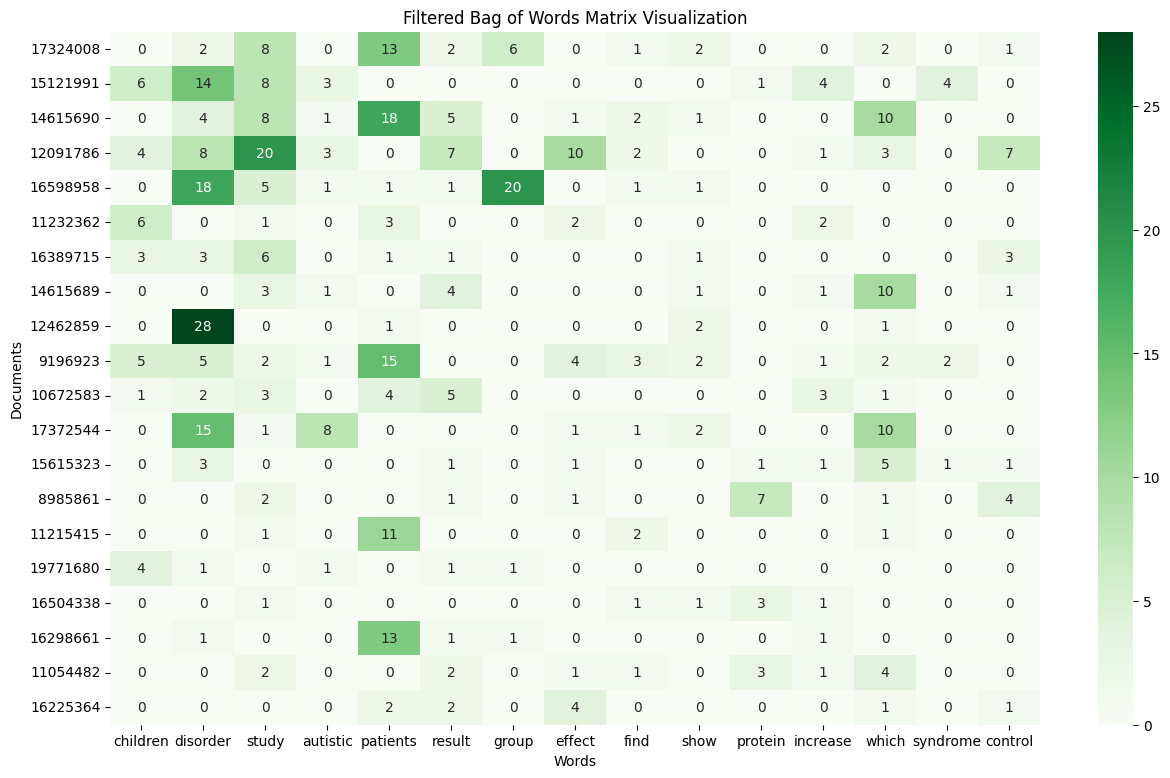

In [12]:
first_row = 0
last_row = 20
first_column = 0
last_column = 15
LBD_06_visualization.plot_bow_tfidf_matrix('Filtered Bag of Words', \
                                           filtered_bow_matrix[first_row:last_row,first_column:last_column], \
                                           filtered_ids_list[first_row:last_row], \
                                           filtered_word_list[first_column:last_column], as_int = True)

**Construct TF-IDF matrix from important words and n-grams**

The next script is designed to create a Term Frequency-Inverse Document Frequency (TF-IDF) matrix from a set of preprocessed documents and then refine this matrix by filtering out less relevant terms.

**Functionality**

1. *Creating the TF-IDF matrix*:<br>
   The script begins by generating a TF-IDF matrix using a list of preprocessed documents:
   - *TF-IDF matrix*: This matrix represents the importance of each word (or n-gram) across all documents in the corpus.
   - *`ngram_size`*: Specifies the size of word sequences to consider (e.g., unigrams, bigrams).
   - *`min_df`*: Filters out terms that appear in fewer than a specified number of documents, reducing noise in the analysis.

   This step is essential for transforming raw text data into a structured format that highlights important terms.

2. *Rearranging the TF-IDF matrix*:
   The script then refines the TF-IDF matrix by rearranging and filtering the terms:
   - *filtering*: The matrix is filtered based on criteria such as the importance of terms, ensuring that only the most relevant words remain.
   - *rearranging*: The matrix is reorganized according to a predefined order, based on the significance of terms or their relevance to specific documents.

   This refinement process is crucial for improving the quality of the analysis by focusing on the most impactful terms, which can lead to more accurate and insightful results.

**Use**

Users can apply this script as part of a larger text mining workflow where the TF-IDF matrix serves as an important step in structuring and analyzing the data. By filtering and refining the matrix, users can ensure that their analysis focuses on the most relevant and meaningful terms, leading to more meaningful insights. In the context of LBD, this script is an essential tool for turning raw text data into actionable insights.

In [13]:
# 1. Creating the TF-IDF matrix
word_list, tfidf_matrix = LBD_03_feature_extraction.create_tfidf(prep_docs_list, ngram_size, min_df)
print('Number of terms in initial vocabulary with all n-grams: ', len(word_list))

# 2. Rearranging the TF-IDF matrix
#    Rearange (filter) the tfidf matrix according to the previously computed order from bow matrix.
tmp_filtered_word_list, tmp_filtered_tfidf_matrix = LBD_03_feature_extraction.filter_matrix_columns(
    word_list, tfidf_matrix, tmp_filter_rows, tmp_filter_columns)

word_list = tmp_filtered_word_list
tfidf_matrix = tmp_filtered_tfidf_matrix
print('Number of terms in preprocessed vocabulary after removing infrequent n-grams: ', len(word_list))

Number of terms in initial vocabulary with all n-grams:  42903
Number of terms in preprocessed vocabulary after removing infrequent n-grams:  42903


**Compute margins for TF-IDF matrix**

This script is designed to analyze and manipulate Term Frequency-Inverse Document Frequency (TF-IDF) data for a corpus of documents. It computes various statistics related to the TF-IDF values for both words and documents, then filters the TF-IDF matrix to reorder it based on the most important words and documents. Note that the importance of words and documents is estimated from the calculated aggregates from TF-IDF matrix. 

**Functionality**

1. *Summing and Maximizing TF-IDF Values*:
   - `sum_count_each_word_in_all_documents`: Calculates the sum of TF-IDF scores for each word across all documents, providing insight into the overall importance of words in the entire corpus.
   - `max_tfidf_each_word_in_all_documents`: Finds the maximum TF-IDF score for each word, indicating the document where each word is most important.
   - `sum_count_all_words_in_each_document`: Computes the sum of TF-IDF scores for all words in each document, which can be used to determine the "weight" or importance of the document itself.
   - `max_tfidf_all_words_in_each_document`: Identifies the highest TF-IDF score for each document, which can help isolate which document contains particularly important terms.

2. *Output Statistics*:
   - The script uses Python's `itertools.islice` function to print a preview of the top 7 values from each TF-IDF statistic. This offers a quick way to inspect the data without overwhelming the output with large lists.

3. *Sorting and Filtering the TF-IDF Matrix*:
   - After calculating the TF-IDF statistics, the script computes an ordering for the rows (documents) and columns (words) based on the maximum TF-IDF values. This ensures that the most important terms and documents are given priority in subsequent analyses.
   - The `filter_matrix` function then reorders the original TF-IDF matrix based on these computed rankings, allowing for a focused view of the most significant content in the corpus.

**Practical applications**

- *Document analysis and classification*: By identifying the most important terms and documents in a corpus, this technique can assist in classifying documents into relevant categories.
- *Term and key concept extraction*: Researchers can use the sum and max TF-IDF scores to isolate critical keywords that may represent novel concepts or ideas in the context of Literature-Based Discovery.
- *Summarization and information retrieval*: By filtering out less important words and documents, this script can help narrow down a large corpus to the most relevant data, making retrieval tasks more efficient.

**Use**

This script is a practical tool for analyzing TF-IDF data in text mining applications. By summing and maximizing TF-IDF scores for words and documents, users can highlight the most significant elements of their corpus. The filtered matrix provides a more focused view of the most important terms, which is highly useful in fields like Literature-Based Discovery and NLP.

In [14]:
# 1. Summing and Maximizing TF-IDF Values
sum_word_tfidf = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, tfidf_matrix)
max_word_tfidf = LBD_03_feature_extraction.max_tfidf_each_word_in_all_documents(word_list, tfidf_matrix)

sum_doc_tfidf = LBD_03_feature_extraction.sum_count_all_words_in_each_document(ids_list, tfidf_matrix)
max_doc_tfidf = LBD_03_feature_extraction.max_tfidf_all_words_in_each_document(ids_list, tfidf_matrix)

# 2. Output Statistics
print('Sum of TF-IDF for each word: ', dict(itertools.islice(sum_word_tfidf.items(), 7)))
print('Max of TF-IDF for each word: ', dict(itertools.islice(max_word_tfidf.items(), 7)))

print('Sum of TF-IDF for each document: ', dict(itertools.islice(sum_doc_tfidf.items(), 7)))
print('Max of TF-IDF for each document: ', dict(itertools.islice(max_doc_tfidf.items(), 7)))

# 3. Sorting and Filtering the TF-IDF Matrix
#    Compute the order of rows (documents) and columns (words) in the tfidf matrix so that the most important words are in the top-left corner. 
filter_columns = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(max_word_tfidf, reverse=True), word_list)
filter_rows = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(max_doc_tfidf, reverse=True), ids_list) 

#    Rearange (filter) the bow matrix according to the previously computed order.
filtered_ids_list, filtered_word_list, filtered_tfidf_matrix = LBD_03_feature_extraction.filter_matrix(
    ids_list, word_list, tfidf_matrix, filter_rows, filter_columns)

Sum of TF-IDF for each word:  {'021s': 0.08650990699720389, '028s': 0.08650990699720389, '0295injg': 0.11187409236931502, '02fold': 0.2123511190800353, '02min': 0.04790407965728707, '038r078': 0.09795656566107928, '03nm': 0.10633460330579322}
Max of TF-IDF for each word:  {'021s': 0.08650990699720389, '028s': 0.08650990699720389, '0295injg': 0.11187409236931502, '02fold': 0.12257323195850983, '02min': 0.04790407965728707, '038r078': 0.09795656566107928, '03nm': 0.10633460330579322}
Sum of TF-IDF for each document:  {'19030398': 2.2753930300892717, '18985132': 7.476385108699896, '18985106': 6.237764595690747, '18985105': 8.962148794959464, '18985104': 6.014124802810563, '18982120': 9.072356798879358, '18958184': 7.017255192384866}
Max of TF-IDF for each document:  {'19030398': 0.588753807646909, '18985132': 0.4277795088876049, '18985106': 0.45276351653089697, '18985105': 0.21825228031856314, '18985104': 0.42638314207845157, '18982120': 0.2884426446840417, '18958184': 0.46516318034513704

**Visualize a part of TF-IDF matrix**

Visualize the upper left part of the TF-IDF matrix. In the TF-IDF matrix, each row corresponds to a document and each column to a word (or n-gram). The values in the matrix represent the Term Frequency Inverse Document Frequency (abbreviated TF-IDF) of the word (term) in the corresponding document and document corpus. TF-IDF is a measure of how relevant a word in a document is in relation to a corpus: the measure increases proportionally to the number of occurrences of a word in the text, but is compensated for by the word frequency in the entire corpus.

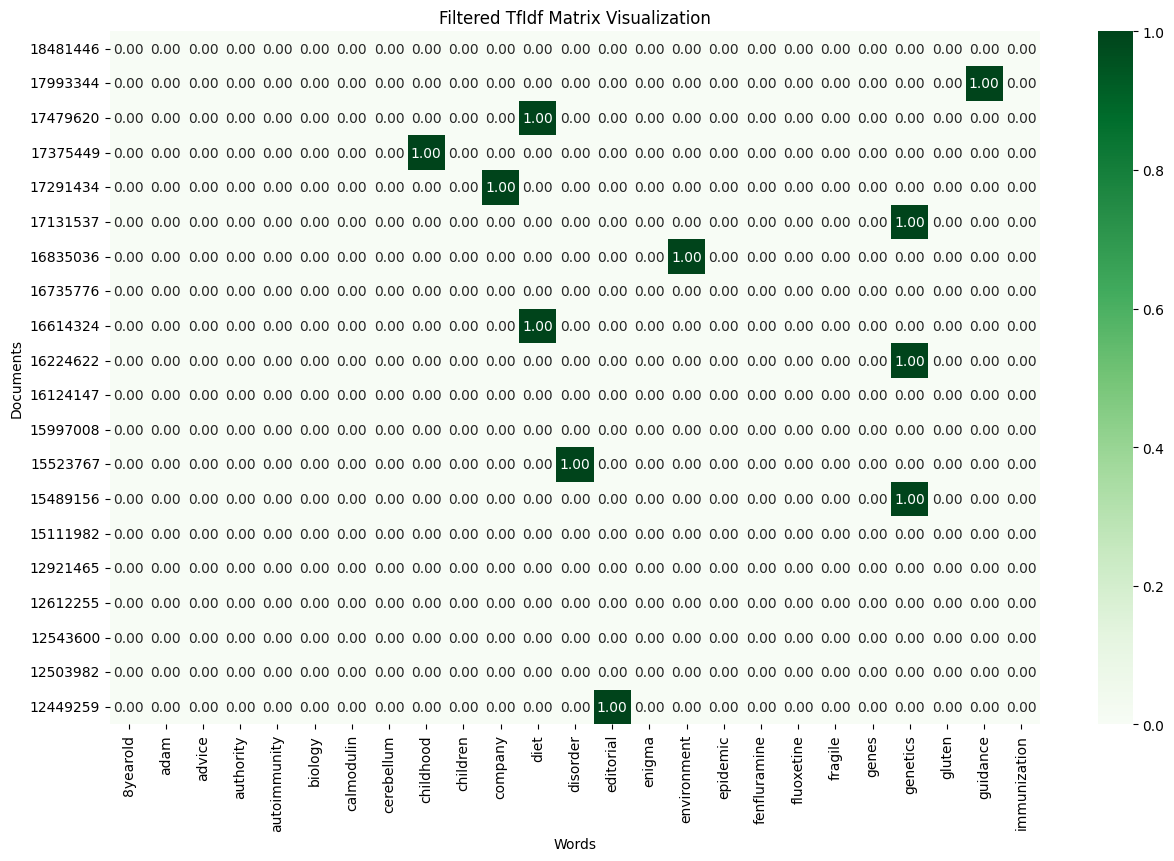

In [15]:
first_row, last_row, first_column, last_column = (0, 20, 0, 25)
LBD_06_visualization.plot_bow_tfidf_matrix('Filtered TfIdf', filtered_tfidf_matrix[first_row:last_row,first_column:last_column], \
                                           filtered_ids_list[first_row:last_row], filtered_word_list[first_column:last_column], as_int = False)

Create a list of domain names of all documents (from the dictionary containing the documents) and a list of unique domain names. There are two distinct domains: *Autism* and *Calcineurin*.

In [23]:
domains_list = LBD_02_data_preprocessing.extract_domain_names_list(prep_docs_dict)
print('Domain names for the first few documents: ', domains_list[:7])
unique_domains_list = LBD_02_data_preprocessing.extract_unique_domain_names_list(prep_docs_dict)
print('A list of all uniques domain names in all the documents: ', unique_domains_list)
for unique_domain in unique_domains_list:
    print('Number of documents in ', unique_domain, ': ', domains_list.count(unique_domain), sep='')

Domain names for the first few documents:  ['Autism', 'Autism', 'Autism', 'Autism', 'Autism', 'Autism', 'Autism']
A list of all uniques domain names in all the documents:  ['Autism', 'Calcineurin']
Number of documents in Autism: 9403
Number of documents in Calcineurin: 4220


Visualize the documents in 2D graph by reducing the dimensionality of tfidf matrix with PCA.

In [46]:
def hex_to_rgba(hex_color, alpha=1.0):
    """
    Converts a hexadecimal color to an RGBA string.

    Args:
        hex_color (str): Hexadecimal color string (e.g., "#FF5733").
        alpha (float): Alpha transparency value (0.0 to 1.0).

    Returns:
        str: RGBA string (e.g., "rgba(255, 87, 51, 0.5)").
    """
    hex_color = hex_color.lstrip('#')  # Remove '#' if present
    r = int(hex_color[0:2], 16)  # Extract and convert the red component
    g = int(hex_color[2:4], 16)  # Extract and convert the green component
    b = int(hex_color[4:6], 16)  # Extract and convert the blue component
    return f'rgba({r}, {g}, {b}, {alpha})'

# Example usage
print(hex_to_rgba("#F24545", 0.2))
print(hex_to_rgba("#F5E943", 0.2))
print(hex_to_rgba("#4EDEE8", 0.2))
print(hex_to_rgba("#91E84E", 0.2))
print()
print(hex_to_rgba("#E502C7", 0.2))
print(hex_to_rgba("#E59102", 0.2))
print(hex_to_rgba("#02E520", 0.2))
print(hex_to_rgba("#0255E5", 0.2))
print()

rgba(242, 69, 69, 0.2)
rgba(245, 233, 67, 0.2)
rgba(78, 222, 232, 0.2)
rgba(145, 232, 78, 0.2)

rgba(229, 2, 199, 0.2)
rgba(229, 145, 2, 0.2)
rgba(2, 229, 32, 0.2)
rgba(2, 85, 229, 0.2)



In [113]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA

def visualize_tfidf_pca_interactive_3(names, domains_list, tfidf_matrix, transpose = False, color_schema = 0):
    tfidf_matrix_transposed = np.squeeze(np.asarray(tfidf_matrix))
    if transpose:
        tfidf_matrix_transposed = tfidf_matrix_transposed.T

    # Apply PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(tfidf_matrix_transposed)
 
    # Generate colors for each point
    if True:
        #colors = ['red', 'orange', 'green', 'blue', 'yellow', 'grey', 'violet', 'brown', 'lime', 'cyan']*12
        if color_schema == 0:
            colors = ['rgba(242, 69, 69, 0.2)', 'rgba(245, 233, 67, 0.2)', 'rgba(78, 222, 232, 0.2)', 'rgba(145, 232, 78, 0.2)',
                      'rgba(229, 2, 199, 0.2)', 'rgba(229, 145, 2, 0.2)', 'rgba(2, 229, 32, 0.2)', 'rgba(2, 85, 229, 0.2)']
            colors_3 = ['rgba(242, 69, 69, 0.9)', 'rgba(245, 233, 67, 0.9)', 'rgba(78, 222, 232, 0.9)', 'rgba(145, 232, 78, 0.9)',
                        'rgba(229, 2, 199, 0.9)', 'rgba(229, 145, 2, 0.9)', 'rgba(2, 229, 32, 0.9)', 'rgba(2, 85, 229, 0.9)']
        elif color_schema == 1:
            colors = ['rgba(229, 2, 199, 0.2)', 'rgba(229, 145, 2, 0.2)', 'rgba(2, 229, 32, 0.2)', 'rgba(2, 85, 229, 0.2)',
                      'rgba(242, 69, 69, 0.2)', 'rgba(245, 233, 67, 0.2)', 'rgba(78, 222, 232, 0.2)', 'rgba(145, 232, 78, 0.2)']
            colors_3 = ['rgba(229, 2, 199, 0.9)', 'rgba(229, 145, 2, 0.9)', 'rgba(2, 229, 32, 0.9)', 'rgba(2, 85, 229, 0.9)',
                        'rgba(242, 69, 69, 0.9)', 'rgba(245, 233, 67, 0.9)', 'rgba(78, 222, 232, 0.9)', 'rgba(145, 232, 78, 0.9)']
        elif color_schema == 2:
            colors = ['rgba(2, 229, 32, 0.2)', 'rgba(2, 85, 229, 0.2)', 'rgba(229, 2, 199, 0.2)', 'rgba(229, 145, 2, 0.2)', 
                      'rgba(242, 69, 69, 0.2)', 'rgba(245, 233, 67, 0.2)', 'rgba(78, 222, 232, 0.2)', 'rgba(145, 232, 78, 0.2)']
            colors_3 = ['rgba(2, 229, 32, 0.9)', 'rgba(2, 85, 229, 0.9)', 'rgba(229, 2, 199, 0.9)', 'rgba(229, 145, 2, 0.9)', 
                        'rgba(242, 69, 69, 0.9)', 'rgba(245, 233, 67, 0.9)', 'rgba(78, 222, 232, 0.9)', 'rgba(145, 232, 78, 0.9)']
        elif color_schema == 11:
            colors = ['rgba(255, 0, 0, 0.2)', 'rgba(0, 0, 255, 0.2)']
            colors_3 = ['rgba(255, 0, 0, 0.9)', 'rgba(0, 0, 255, 0.9)']
        elif color_schema == 12:
            colors = ['rgba(255, 153, 153, 0.2)', 'rgba(153, 153, 255, 0.2)']
            colors_3 = ['rgba(255, 153, 153, 0.9)', 'rgba(153, 153, 255, 0.9)']
        elif color_schema == 13:
            colors = ['rgba(255, 0, 0, 0.2)', 'rgba(255, 128, 0, 0.2)', 'rgba(0, 0, 255, 0.2)', 'rgba(128, 0, 255, 0.2)']
            colors_3 = ['rgba(255, 0, 0, 0.9)', 'rgba(255, 128, 0, 0.9)', 'rgba(0, 0, 255, 0.9)', 'rgba(128, 0, 255, 0.9)']
    else:
        colors = ['red', 'green', 'blue', 'yellow', 'black', 'grey', 'violet', 'brown', 'lime', 'cyan']*12

    # Determine unique clusters
    unique_clusters = list(set(domains_list))
    unique_clusters.sort()
    
    # Compute the centroid of the PCA result
    centroid = pca_result.mean(axis=0)
    
    # Create interactive plot
    fig = go.Figure()

    # PCA Scatter plot with random colors
    for cluster_num in range(len(unique_clusters)):
        cluster_docs_indices = [i for i, label in enumerate(domains_list) if label == unique_clusters[cluster_num]]

        # Compute centroid for the current cluster
        centroid_x = np.mean(pca_result[cluster_docs_indices, 0])
        centroid_y = np.mean(pca_result[cluster_docs_indices, 1])

        fig.add_trace(go.Scatter(x=pca_result[cluster_docs_indices, 0], y=pca_result[cluster_docs_indices, 1], 
                                 mode='markers+text',
                                 # marker=dict(size=8, color=colors[cluster_num]), # , color=colors[cluster_num]
                                 marker=dict(size=8, color=colors[cluster_num], symbol='circle', line=dict(color='rgba(0, 0, 0, 0.1)', width=1)), 
                                 name=unique_clusters[cluster_num],
                                 hovertext=[names[i] for i in cluster_docs_indices], # this text is shown on hover
                                 text='', # [names[i] for i in cluster_docs_indices], # this text is set to show always
                                 textposition='bottom center'))

        # Plot the centroid of the current cluster
        fig.add_trace(go.Scatter(x=[centroid_x], y=[centroid_y],
                                 mode='markers+text',
                                 marker=dict(size=16, color=colors_3[cluster_num], symbol='star', line=dict(color='rgba(0, 0, 0, 0.5)', width=2)),
                                 name='Centroid ' + unique_clusters[cluster_num],
                                 hovertext='Centroid of ' + unique_clusters[cluster_num],
                                 text=unique_clusters[cluster_num],
                                 textposition='bottom center'))

    # Plot the centroid of the whole set of documents
    fig.add_trace(go.Scatter(x=[centroid[0]], y=[centroid[1]],
                             mode='markers',
                             marker=dict(size=20, color='black', symbol='cross'),
                             name='The main centroid',
                             hovertext=['The main centroid']))

    fig.update_layout(title="PCA Visualization of TF-IDF Vectors",
                      hovermode='closest',
                      showlegend=True,
                      width=1100,  # Set the width of the figure
                      height=1100)  # Set the height of the figure
    
    fig.show()

In [105]:
visualize_tfidf_pca_interactive_3(ids_list, domains_list, tfidf_matrix, transpose = False, color_schema = 11)
#LBD_06_visualization.visualize_tfidf_pca_interactive(ids_list, domains_list, tfidf_matrix, transpose = False)

In [106]:
print(type(tfidf_matrix))

<class 'numpy.matrix'>


In [107]:
from sklearn.cluster import KMeans

# Cluster the documents using KMeans
n_clusters = 2
tfidf_array = np.asarray(tfidf_matrix)
kmeans = KMeans(n_clusters=n_clusters, random_state=321).fit(tfidf_array)
cluster_assignments = list(np.asarray(kmeans.labels_))
cluster_assignments = [str(i) for i in cluster_assignments]
# print(cluster_assignments[:50])
# print(len(cluster_assignments), cluster_assignments.count('0'), cluster_assignments.count('1'))

unique_cluster_assignments = list(set(cluster_assignments))
print('A list of all uniques domain names in all the documents: ', unique_cluster_assignments)
for unique_cluster in unique_cluster_assignments:
    print('Number of documents in ', unique_cluster, ': ', cluster_assignments.count(unique_cluster), sep='')


A list of all uniques domain names in all the documents:  ['1', '0']
Number of documents in 1: 4531
Number of documents in 0: 9092


In [108]:
visualize_tfidf_pca_interactive_3(ids_list, cluster_assignments, tfidf_matrix, transpose = False, color_schema = 12)
#LBD_06_visualization.visualize_tfidf_pca_interactive(ids_list, cluster_assignments, tfidf_matrix, transpose = False)

In [109]:
dl_ca = []
my_lines = []
i = 0
for dl, ca in zip(domains_list, cluster_assignments):
    dl_ca.append(dl + '-' + ca)
    if (dl == 'Alzheimer') and (ca == "1"):
        my_lines.append(lines[i])        
    if (dl == 'GIMB') and (ca == "0"):
        my_lines.append(lines[i])
    i += 1

from collections import Counter

# Step 1: Use Counter to count the frequencies of each value
frequencies = Counter(dl_ca)

# Step 2: Display the frequencies
for value, count in frequencies.items():
    print(f"Value {value} appears {count} times")

print(dl_ca)

Value Autism-0 appears 9047 times
Value Autism-1 appears 356 times
Value Calcineurin-1 appears 4175 times
Value Calcineurin-0 appears 45 times
['Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-1', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-1', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-1', 'Autism-0', 'Autism-1', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Autism-0', 'Aut

In [114]:
visualize_tfidf_pca_interactive_3(ids_list, dl_ca, tfidf_matrix, transpose = False, color_schema = 13)
#LBD_06_visualization.visualize_tfidf_pca_interactive(ids_list, dl_ca, tfidf_matrix, transpose = False)

In [115]:
def create_crosstab(list1, list2):
    # Check if the two lists have the same length
    if len(list1) != len(list2):
        raise ValueError("The two lists must have the same length.")

    # Initialize the crosstab dictionary
    crosstab = defaultdict(lambda: defaultdict(int))

    # Populate the crosstab with frequency counts
    for val1, val2 in zip(list1, list2):
        crosstab[val1][val2] += 1

    # Display the crosstab as a matrix
    headers = sorted(crosstab.keys())
    sub_headers = sorted({val for sublist in crosstab.values() for val in sublist.keys()})

    print("\t" + "\t".join(map(str, sub_headers)))
    for h in headers:
        row = [str(crosstab[h][sh]) for sh in sub_headers]
        print(f"{h}\t" + "\t".join(row))

create_crosstab(domains_list, cluster_assignments)

	0	1
Autism	9047	356
Calcineurin	45	4175


In [118]:
selectors = []
for i, dl in enumerate(domains_list):
    if i % 25 == 0:
        selectors.append(True)
    else:
        selectors.append(False)

visualize_tfidf_pca_interactive_3([element for element, select in zip(ids_list, selectors) if select], [element for element, select in zip(dl_ca, selectors) if select], tfidf_matrix[selectors,:], transpose = False, color_schema = 13)
#LBD_06_visualization.visualize_tfidf_pca_interactive([element for element, select in zip(ids_list, selectors) if select], [element for element, select in zip(dl_ca, selectors) if select], tfidf_matrix[selectors,:], transpose = False)

In [ ]:
domains_list_boolean = [True if name == unique_domains_list[0] else False for name in domains_list]

from collections import Counter

# Step 1: Use Counter to count the frequencies of each value
frequencies = Counter(domains_list_boolean)

# Step 2: Display the frequencies
for value, count in frequencies.items():
    print(f"Value {value} appears {count} times")

In [ ]:
# Example TF-IDF matrix with 5 documents (rows) and 4 words (columns)
f_matrix = np.array([
        [0.1, 0.3, 0.4, 0.2],
        [0.2, 0.0, 0.0, 0.6],
        [0.3, 0.4, 0.0, 0.2],
        [0.4, 0.1, 0.1, 0.5],
        [0.5, 0.5, 0.6, 0.0]
    ])
    
# Rows to filter (e.g., we choose rows 0, 2, and 4)
row_indices = [0, 2, 4]

row_list = [True, True, False, False, True]

print(f_matrix[row_indices, :])

print(f_matrix[row_list, :])


In [ ]:
mm = [True, True, False, True, False]
[not m for m in mm]

In [ ]:
# Prepare a list of outlier documents based ob TF-IDF matrix; by the same token, a list of outlier words can be identified

# utility for finding outlier documents from TF-IDF matrix

def find_document_outliers(tfidf_matrix, n_outliers=1):
    """
    Identify outliers based on cosine distance from the centroid of all document vectors.
    
    Parameters:
    - tfidf_matrix: 2D numpy array of shape (n_docs, n_features), the TF-IDF matrix.
    - outlier_fraction: float, the fraction of documents to consider as outliers.
    
    Returns:
    - outlier_indices: List of indices of the documents identified as outliers.
    """
    
    # Step 1: Compute the centroid of the TF-IDF vectors
    centroid = np.mean(tfidf_matrix, axis=0)
    # print(centroid)
    
    # Step 2: Compute cosine distances between each document vector and the centroid
    # Since we are computing cosine distance from the centroid, reshape centroid to (1, -1)
    distances = cosine_distances(tfidf_matrix, centroid.reshape(1, -1)).flatten()
    # print(distances)
    
    # Step 3: Determine the number of outliers to select
    # n_docs = tfidf_matrix.shape[0]
    # n_outliers = int(np.ceil(outlier_fraction * n_docs))
    
    # Step 4: Find the indices of the top N documents with the highest distances
    if n_outliers < 0:
        outlier_indices = np.argsort(distances)[-n_outliers:]
    else:
        outlier_indices = np.argsort(distances)[-n_outliers:]
    
    return outlier_indices

# Example usage:
# Assuming tfidf_matrix is a numpy array of shape (n_docs, n_features) representing the TF-IDF matrix
# outliers = find_outliers(tfidf_matrix, outlier_fraction=0.1)
# print(outliers)  # List of indices of the 10% most outlier documents


# utility for finding outlier words from TF-IDF matrix

def find_word_outliers(tfidf_matrix, vocabulary, n_outliers=1):
    """
    Identify outlier words based on cosine distance from the centroid of all word vectors.
    
    Parameters:
    - tfidf_matrix: 2D numpy array of shape (n_docs, n_features), the TF-IDF matrix.
    - vocabulary: List of words corresponding to the columns (features) in the TF-IDF matrix.
    - outlier_fraction: float, the fraction of words to consider as outliers.
    
    Returns:
    - outlier_words: List of words identified as outliers.
    """
    
    # Step 1: Compute the centroid of the word vectors (columns)
    centroid = np.mean(tfidf_matrix, axis=1)  # Centroid of columns (words)
    # print(centroid)
    
    # Step 2: Compute cosine distances between each word vector and the centroid
    # Since we are calculating cosine distance for words (columns), we transpose the matrix
    distances = cosine_distances(tfidf_matrix.T, centroid.reshape(1, -1)).flatten()
    # print(distances)
    
    # Step 3: Determine the number of outlier words to select
    # n_words = tfidf_matrix.shape[1]
    # n_outliers = int(np.ceil(outlier_fraction * n_words))
    
    # Step 4: Find the indices of the top N words with the highest distances
    if n_outliers < 0:
        outlier_indices = np.argsort(distances)[:-n_outliers]
    else:
        outlier_indices = np.argsort(distances)[-n_outliers:]
    
    # Step 5: Retrieve the corresponding outlier words using the vocabulary
    outlier_words = [vocabulary[i] for i in outlier_indices]
    
    return outlier_words

# Example usage:
# Assuming tfidf_matrix is a numpy array of shape (n_docs, n_features) representing the TF-IDF matrix
# and vocabulary is a list of words corresponding to the columns of the TF-IDF matrix
# outliers = find_word_outliers(tfidf_matrix, vocabulary, outlier_fraction=0.1)
# print(outliers)  # List of 10% most outlier words

# prep_docs_list, ids_list, word_list, tfidf_matrix

print('Matrix rows, columns: ', tfidf_matrix.shape) # rows, columns
tfidf_matrix = np.asarray(tfidf_matrix)
# print(type(tfidf_matrix))

# Find outlier documents
outlier_docs = find_document_outliers(tfidf_matrix,  n_outliers=20)
print('Outlier docs indeces: ', outlier_docs) # list of documents is lines and preprocessed in prep_docs_list; ids_list contains document ids
outlier_docs_list = outlier_docs.astype(int).tolist()
print('Outlier docs ids: ', [ids_list[i] for i in outlier_docs_list])

# Find representative documents
representative_docs = find_document_outliers(tfidf_matrix,  n_outliers=-20)
print('Representative docs indeces: ', representative_docs) # list of documents is lines and preprocessed in prep_docs_list; ids_list contains document ids
representative_docs_list = representative_docs.astype(int).tolist()
print('Representative docs ids: ', [ids_list[i] for i in representative_docs_list])

# Find outlier words
outlier_words = find_word_outliers(tfidf_matrix, word_list,  n_outliers=20)
print('Outlier words: ', outlier_words)

# Find representative words
representative_words = find_word_outliers(tfidf_matrix, word_list,  n_outliers=-20)
print('Representative words: ', representative_words)

# Find again outlier documents, this time with the proper size for furter processing
outlier_docs = find_document_outliers(tfidf_matrix,  n_outliers=7000)
outlier_docs_list = outlier_docs.astype(int).tolist()

In [ ]:
# new implementation of OntoGen similarity to domain centroids

def find_document_outliers(tfidf_matrix, domains_list_boolean, domain_ind, n_outliers=1):
    """
    Identify outliers based on cosine distance from the centroid of all document vectors.
    
    Parameters:
    - tfidf_matrix: 2D numpy array of shape (n_docs, n_features), the TF-IDF matrix.
    - outlier_fraction: float, the fraction of documents to consider as outliers.
    
    Returns:
    - outlier_indices: List of indices of the documents identified as outliers.
    """
    
    # Step 1: Compute the centroid of the TF-IDF vectors
    domains_list_boolean_negative = [not m for m in domains_list_boolean]
    centroid = np.mean(tfidf_matrix, axis=0)
    centroid0 = np.mean(tfidf_matrix[domains_list_boolean,:], axis=0)
    centroid1 = np.mean(tfidf_matrix[domains_list_boolean_negative,:], axis=0)
    # print(centroid0)
    # print(centroid1)
    
    # Step 2: Compute cosine distances between each document vector and the centroid
    # Since we are computing cosine distance from the centroid, reshape centroid to (1, -1)
    distances = cosine_distances(tfidf_matrix, centroid.reshape(1, -1)).flatten()
    distances0 = cosine_distances(tfidf_matrix, centroid0.reshape(1, -1)).flatten()
    distances1 = cosine_distances(tfidf_matrix, centroid1.reshape(1, -1)).flatten()
    # print(distances0)
    # print(distances1)
    
    # Step 3: Determine the number of outliers to select
    # n_docs = tfidf_matrix.shape[0]
    # n_outliers = int(np.ceil(outlier_fraction * n_docs))
    
    # Step 4: Find the indices of the top N documents with the highest distances
    if n_outliers < 0:
        outlier_indices = np.argsort(distances0)[-n_outliers:]
    else:
        outlier_indices = np.argsort(distances1)[-n_outliers:]
    #print(type(outlier_indices))

    distances = []
    for i in range(len(domains_list_boolean)):
        distances.append(distances0[i]-distances1[i])

    outlier_indices = []
    for i in range(len(domains_list_boolean)):
        if domain_ind == 0:
            if domains_list_boolean[i]: # domain0 - autism
                if distances[i] > 0:
                    outlier_indices.append(i)
        else:
            if not domains_list_boolean[i]: # domain1 - calcineurin
                if distances[i] < 0:
                    outlier_indices.append(i)
    
    return np.array(outlier_indices)

# Example usage:
# Assuming tfidf_matrix is a numpy array of shape (n_docs, n_features) representing the TF-IDF matrix
# outliers = find_outliers(tfidf_matrix, outlier_fraction=0.1)
# print(outliers)  # List of indices of the 10% most outlier documents


# utility for finding outlier words from TF-IDF matrix

def find_word_outliers(tfidf_matrix, vocabulary, n_outliers=1):
    """
    Identify outlier words based on cosine distance from the centroid of all word vectors.
    
    Parameters:
    - tfidf_matrix: 2D numpy array of shape (n_docs, n_features), the TF-IDF matrix.
    - vocabulary: List of words corresponding to the columns (features) in the TF-IDF matrix.
    - outlier_fraction: float, the fraction of words to consider as outliers.
    
    Returns:
    - outlier_words: List of words identified as outliers.
    """
    
    # Step 1: Compute the centroid of the word vectors (columns)
    centroid = np.mean(tfidf_matrix, axis=1)  # Centroid of columns (words)
    # print(centroid)
    
    # Step 2: Compute cosine distances between each word vector and the centroid
    # Since we are calculating cosine distance for words (columns), we transpose the matrix
    distances = cosine_distances(tfidf_matrix.T, centroid.reshape(1, -1)).flatten()
    # print(distances)
    
    # Step 3: Determine the number of outlier words to select
    # n_words = tfidf_matrix.shape[1]
    # n_outliers = int(np.ceil(outlier_fraction * n_words))
    
    # Step 4: Find the indices of the top N words with the highest distances
    if n_outliers < 0:
        outlier_indices = np.argsort(distances)[:-n_outliers]
    else:
        outlier_indices = np.argsort(distances)[-n_outliers:]
    
    # Step 5: Retrieve the corresponding outlier words using the vocabulary
    outlier_words = [vocabulary[i] for i in outlier_indices]
    
    return outlier_words

# Example usage:
# Assuming tfidf_matrix is a numpy array of shape (n_docs, n_features) representing the TF-IDF matrix
# and vocabulary is a list of words corresponding to the columns of the TF-IDF matrix
# outliers = find_word_outliers(tfidf_matrix, vocabulary, outlier_fraction=0.1)
# print(outliers)  # List of 10% most outlier words

# prep_docs_list, ids_list, word_list, tfidf_matrix

print('Matrix rows, columns: ', tfidf_matrix.shape) # rows, columns
tfidf_matrix = np.asarray(tfidf_matrix)
# print(type(tfidf_matrix))

# Find outlier documents
outlier_docs = find_document_outliers(tfidf_matrix,  domains_list_boolean, 0, n_outliers=20)
print('Outlier docs indeces: ', outlier_docs) # list of documents is lines and preprocessed in prep_docs_list; ids_list contains document ids
print(len(outlier_docs))
outlier_docs_list = outlier_docs.astype(int).tolist()
print('Outlier docs ids: ', [ids_list[i] for i in outlier_docs_list])

# Find representative documents
representative_docs = find_document_outliers(tfidf_matrix,  domains_list_boolean, 0, n_outliers=-20)
print('Representative docs indeces: ', representative_docs) # list of documents is lines and preprocessed in prep_docs_list; ids_list contains document ids
representative_docs_list = representative_docs.astype(int).tolist()
print('Representative docs ids: ', [ids_list[i] for i in representative_docs_list])

# Find outlier words
outlier_words = find_word_outliers(tfidf_matrix, word_list,  n_outliers=20)
print('Outlier words: ', outlier_words)

# Find representative words
representative_words = find_word_outliers(tfidf_matrix, word_list,  n_outliers=-20)
print('Representative words: ', representative_words)

# Find again outlier documents, this time with the proper size for furter processing
outlier_docs0 = find_document_outliers(tfidf_matrix,  domains_list_boolean, 0, n_outliers=500)
outlier_docs0_list = outlier_docs.astype(int).tolist()

outlier_docs1 = find_document_outliers(tfidf_matrix,  domains_list_boolean, 1, n_outliers=500)
outlier_docs1_list = outlier_docs.astype(int).tolist()

print(outlier_docs0)
print(outlier_docs1)

In [ ]:
oznake = []
my_lines = []
for i in range(len(domains_list_boolean)):
    if domains_list_boolean[i]:
        if i in outlier_docs0:
            oznake.append('Autism - outlier')
            my_lines.append(lines[i])
        else:
            oznake.append('Autism - normal')
    else:
        if i in outlier_docs1:
            oznake.append('Calcineurin - outlier')
            my_lines.append(lines[i])
        else:
            oznake.append('Calcineurin - normal')

from collections import Counter

# Step 1: Use Counter to count the frequencies of each value
frequencies = Counter(oznake)

# Step 2: Display the frequencies
for value, count in frequencies.items():
    print(f"Value {value} appears {count} times")

In [ ]:
LBD_06_visualization.visualize_tfidf_pca_interactive(ids_list, oznake, tfidf_matrix, transpose = False)

In [ ]:
len(my_lines)

In [22]:
# Specify the file path (or name) where the list will be saved
file_path0 = 'output0.txt'
file_path1 = 'output1.txt'

# Open the file in write mode ('w') and write each string to the file
with open(file_path0, 'w', encoding="utf-8") as file:
    for line in my_lines:
        file.write(line)

LBD_01_data_acquisition.convert_file_to_ascii_encoding(file_path0, file_path1)